In [2]:
import ROOT
from IPython.display import  Audio
sound_file= 'sounds/dscybsit.wav'

Welcome to JupyROOT 6.16/00


In [3]:
file = ROOT.TFile.Open("../output/Charmonium2018B_test/psi_charmonium_2018B.root")

mass = ROOT.RooRealVar("mass", "", 3.40, 4.00)

data = ROOT.RooDataSet("data", "", file.Psi, ROOT.RooArgSet(mass))


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Eval -- RooAbsReal::attachToTree(mass) TTree Float_t branch mass will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 42404 out of range events


In [4]:
#Signal PDFs

## Signal PDF: Crystal ball and gaussian

frac_gauss = ROOT.RooRealVar("frac_gauss","", 0.4, 0.0, 1.0)
mean = ROOT.RooRealVar("mean", "", 3.686, 3.40, 4.00)
sigma_gauss = ROOT.RooRealVar("sigma_gauss", "", 0.02, 0.000001, 1)

frac_cb = ROOT.RooRealVar("yield_cb","", 0.6, 0.0, 1.0)
sigma_cb = ROOT.RooRealVar("sigma_cb", "", 0.02, 0.000001, 1)

alpha = ROOT.RooRealVar("alpha", "", 1.4, 0, 10)

n = ROOT.RooRealVar("n", "", 30, 0, 150)
n.setConstant(True)

signal1 = ROOT.RooGaussian("gauss", "", mass, mean, sigma_gauss)
signal2 = ROOT.RooCBShape("crystal ball", "", mass, mean, sigma_cb, alpha, n)

In [5]:
# Background PDF
exp_coef = ROOT.RooRealVar("exp_coef", "", -3, -5, 5)

back_exp = ROOT.RooExponential("back_exp", "", mass, exp_coef)

In [6]:
# Model definition and fitting
model = ROOT.RooAddPdf("model", "", ROOT.RooArgList(signal1, signal2, back_exp),
                       ROOT.RooArgList(frac_gauss, frac_cb), ROOT.kTRUE)

In [7]:
result = model.fitTo(data, ROOT.RooFit.Save())

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gauss,crystal ball,back_exp)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha        1.40000e+00  7.00000e-01    0.00000e+00  1.00000e+01
     2 exp_coef    -3.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     3 frac_gauss   4.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     4 mean         3.68600e+00  6.00000e-02    3.40000e+00  4.00000e+00
     5 sigma_cb     2.00000e-02  9.99950e-03    1.00000e-06  1.00000e+00
     6 sigma_gauss   2.00000e-02  9.99950e-03    1.00000e-06  1.00000e+00
     7 yield_cb     6.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (gauss,crystal ball)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (back_exp)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file Psi_fit.png has been created


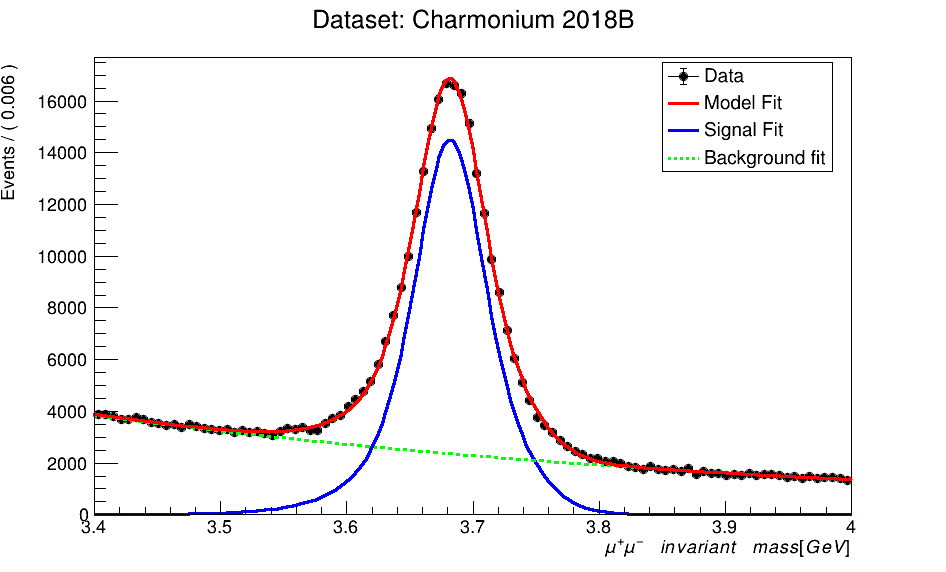

In [8]:
## Plots

# Colors and styles
colors = {"model" : 2, "signal" : 4, "background" : 3}
styles = {"model" : 1, "signal" : 1, "background" : 2}

# Canvas Definition
can = ROOT.TCanvas("can", "histograms", 950, 600)

# Frame creation
frame1 = mass.frame(ROOT.RooFit.Title("Dataset: Charmonium 2018B"), ROOT.RooFit.Bins(100))
frame1.GetXaxis().SetTitle("#\mu^+\mu^- #invariant \ mass[GeV]")

# Data
data.plotOn(frame1, ROOT.RooFit.Name("Data"), ROOT.RooFit.DataError(ROOT.RooAbsData.SumW2))

# Signal
model.plotOn(frame1, ROOT.RooFit.Name("Signal"), ROOT.RooFit.Components("gauss,crystal ball"), ROOT.RooFit.LineStyle(styles["signal"]), ROOT.RooFit.LineColor(colors["signal"]))

# Background
model.plotOn(frame1, ROOT.RooFit.Name("Background"), ROOT.RooFit.Components("back_exp"), ROOT.RooFit.LineStyle(styles["background"]), ROOT.RooFit.LineColor(colors["background"]))

# Model
model.plotOn(frame1, ROOT.RooFit.Name("Model"), ROOT.RooFit.LineStyle(styles["model"]), ROOT.RooFit.LineColor(colors["model"]))

## ChiSquare computation
n_param = result.floatParsFinal().getSize()
reduce_chi_square = frame1.chiSquare(n_param)
## Legends

leg = ROOT.TLegend(0.7, 0.7, 0.88, 0.89)
leg.AddEntry(frame1.findObject("Data"), "Data", "LEP")
leg.AddEntry(frame1.findObject("Model"), "Model Fit", "L")
leg.AddEntry(frame1.findObject("Signal"), "Signal Fit", "L")
leg.AddEntry(frame1.findObject("Background"), "Background fit", "L")

frame1.Draw()
leg.Draw("same")

can.Draw()

can.SaveAs("Psi_fit.png")

In [9]:
reduce_chi_square

1.769410444226279

In [10]:
## Compute the effective sigma
# SigmaEff = fractionGauss * sigmaGauss + (1-fractionGauss) * sigmaCB
sigma_effective = (frac_gauss.getVal() * sigma_gauss.getVal()**2 + (1 - frac_gauss.getVal()) * sigma_cb.getVal()**2)**(0.5)
sigma_effective
# Ref: https://root-forum.cern.ch/t/how-to-calculate-effective-sigma/39472/3

0.03948662662265704

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can2


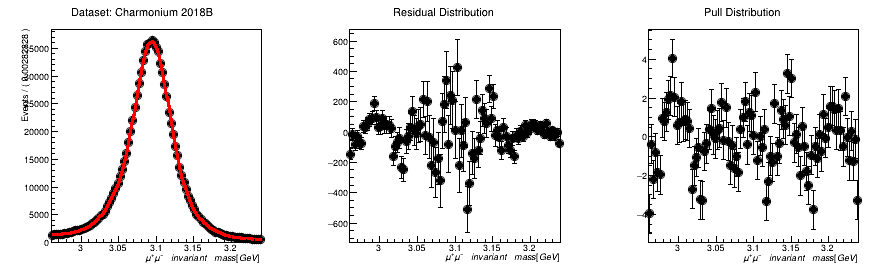

In [21]:
# Takes pull and residual histograms
histpull = frame1.pullHist()
histresid = frame1.residHist()

# New frame to draw residual distribution
frame2 = mass.frame(ROOT.RooFit.Title("Residual Distribution"))
frame2.GetXaxis().SetTitle()

frame2 = mass.frame(ROOT.RooFit.Title("Residual Distribution"))
frame2.GetXaxis().SetTitle("#\mu^+\mu^- #invariant \ mass[GeV]")

# Add the distribution to the frame
frame2.addPlotable(histresid, "P")

# New frame to draw pull distribution
frame3 = mass.frame(ROOT.RooFit.Title("Pull Distribution"))
frame3.GetXaxis().SetTitle("#\mu^+\mu^- #invariant \ mass[GeV]")

# Add the distribution to the frame
frame3.addPlotable(histpull, "P")

# New canvas to draw our distributions
can2 = ROOT.TCanvas("can2", "Residual_pull", 900, 300)
can2.Divide(3)

# Plot for data and fit
can2.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
frame1.GetYaxis().SetTitleOffset(1.6)
frame1.Draw()

# Plot for residual distribution
can2.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
frame2.GetYaxis().SetTitleOffset(1.6)
frame2.Draw()

# Plot for pull distribution

can2.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
frame3.GetYaxis().SetTitleOffset(1.6)
frame3.Draw()

can2.Draw()

In [22]:
# To save workspace
wspace = ROOT.RooWorkspace("Dstar fit")

getattr(wspace, "import")(data)
getattr(wspace, "import")(model)

wspace.writeToFile("Jpsi_fit.root")

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing dataset data
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooAddPdf::model
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooGaussian::gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::sigma gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::frac_gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooCBShape::crystal ball
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::sigma cb
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::alpha
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::n
[#1] INFO:ObjectHandli

In [23]:
Audio(sound_file, autoplay=True)